## 2. Data Analyst - Run SQL on tables and plot data

### This notebook runs some SQL against BigQuery on tables and plots the data

In [1]:
from google.cloud import bigquery
import json

client = bigquery.Client()

In [2]:
project_id = !gcloud config list --format 'value(core.project)' 2>/dev/null 
dataset_name = project_id[0] + '-raw'
dataset_name = dataset_name.replace('-', '_')
table_path = "`" + project_id[0] + '.' + dataset_name + '.transaction_data_train`' 
table_path

'`thatistoomuchdata.thatistoomuchdata_raw.transaction_data_train`'

**TODO**
* Substitute **table_path** in the FROM clauses below

#### Use Ipython magics to query BQ

* Learn more about Ipython magics for BigQuery [[here]](https://googleapis.dev/python/bigquery/latest/magics.html)

In [5]:
%%bigquery 
SELECT 
    isFraud,
    COUNT(*) as count
FROM `thatistoomuchdata.thatistoomuchdata_raw.transaction_data_train`
GROUP BY isFraud

,isFraud,count
0,0,5084177
1,1,6515


In [7]:
%%bigquery
SELECT 
    type,
    COUNT(*) as Transactions,
    AVG(amount) as Average_amount
FROM `thatistoomuchdata.thatistoomuchdata_raw.transaction_data_train`
GROUP BY type

,type,Transactions,Average_amount
0,TRANSFER,426304,910769.986844
1,CASH_OUT,1790849,176275.914919
2,DEBIT,33232,5429.525721
3,CASH_IN,1119488,168971.357671
4,PAYMENT,1720819,13060.837903


In [9]:
%%bigquery
SELECT 
    type, 
    SUM(amount)/1000000000 as total_amount_in_billion,
    SUM(CASE WHEN isFraud=1 THEN amount ELSE 0 END)/1000000000 as fraud_amount_in_billion,
    SUM(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) as fraud_cases,  
FROM `thatistoomuchdata.thatistoomuchdata_raw.transaction_data_train`
GROUP BY type

,type,total_amount_in_billion,fraud_amount_in_billion,fraud_cases
0,TRANSFER,388.264888,4.753105,3235
1,CASH_OUT,315.683546,4.678375,3280
2,DEBIT,0.180434,0.000000,0
3,CASH_IN,189.161407,0.000000,0
4,PAYMENT,22.475338,0.000000,0


#### Use Spark to query BQ table 

Enable Apache Arrow to allow faster conversion from Spark DataFrame to Pandas DataFrame [[doc]](https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html)

In [10]:
sql = f"""
SELECT 
    type,
    COUNT(*) as Transactions,
    AVG(amount) as Average_amount,
    SUM(amount)/1000000000 as total_amount_in_billion,
    SUM(CASE WHEN isFraud=1 THEN amount ELSE 0 END)/1000000000 as fraud_amount_in_billion,
    SUM(CASE WHEN isFraud=1 THEN 1 ELSE 0 END) as fraud_cases,    
FROM {table_path}
GROUP BY type
"""

In [11]:
df_transaction_data_train = client.query(sql).to_dataframe()

In [12]:
type(df_transaction_data_train)

pandas.core.frame.DataFrame

In [13]:
df_transaction_data_train.head()

,type,Transactions,Average_amount,total_amount_in_billion,fraud_amount_in_billion,fraud_cases
0,TRANSFER,426304,910769.986844,388.264888,4.753105,3235
1,CASH_OUT,1790849,176275.914919,315.683546,4.678375,3280
2,DEBIT,33232,5429.525721,0.180434,0.000000,0
3,CASH_IN,1119488,168971.357671,189.161407,0.000000,0
4,PAYMENT,1720819,13060.837903,22.475338,0.000000,0


### Plot data 

In [14]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='type'>

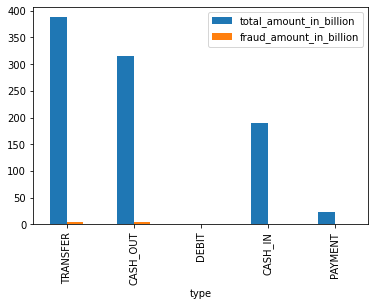

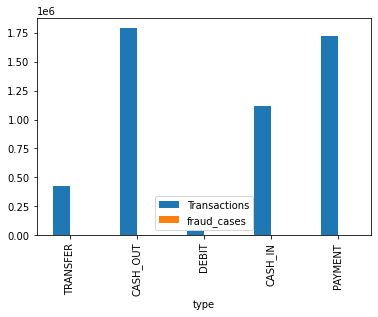

In [15]:
df_transaction_data_train.plot(x="type", y=["total_amount_in_billion", "fraud_amount_in_billion"], rot=90, kind="bar")
df_transaction_data_train.plot(x="type", y=["Transactions", "fraud_cases"], rot=90, kind="bar")

In [16]:
df_transaction_data_train.set_index('type', inplace=True)
df_transaction_data_train.head()

,Transactions,Average_amount,total_amount_in_billion,fraud_amount_in_billion,fraud_cases
type,,,,,
TRANSFER,426304,910769.986844,388.264888,4.753105,3235
CASH_OUT,1790849,176275.914919,315.683546,4.678375,3280
DEBIT,33232,5429.525721,0.180434,0.000000,0
CASH_IN,1119488,168971.357671,189.161407,0.000000,0
PAYMENT,1720819,13060.837903,22.475338,0.000000,0
